## Analysis of FF Left Ventricle preprocessed using scanpy and SVG identification with SpatialDE

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
import scanorama
import csv
from sklearn.metrics.pairwise import cosine_distances

import SpatialDE

plt.rcParams['figure.figsize']=(8,8)

%load_ext autoreload
%autoreload 2

print(sc.__version__)

1.8.1


In [2]:
#load in data directly from 10X website
adata = sc.datasets.visium_sge('V1_Human_Heart')
adata.var_names_make_unique()
adata.obs

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


in_tissue  array_row  array_col
AAACAAGTATCTCCCA-1          1         50        102
AAACACCAATAACTGC-1          1         59         19
AAACAGAGCGACTCCT-1          1         14         94
AAACAGCTTTCAGAAG-1          1         43          9
AAACAGGGTCTATATT-1          1         47         13
...                       ...        ...        ...
TTGTTGTGTGTCAAGA-1          1         31         77
TTGTTTCACATCCAGG-1          1         58         42
TTGTTTCATTAGTCTA-1          1         60         30
TTGTTTCCATACAACT-1          1         45         27
TTGTTTGTGTAAATTC-1          1          7         51

[4247 rows x 3 columns]

In [3]:
#Calculate some QC metrics for the data
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [4]:
#look at adata structure
adata.var

gene_ids    feature_types  genome     mt  \
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False   
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False   
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False   
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False   
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False   
...                      ...              ...     ...    ...   
AC141272.1   ENSG00000277836  Gene Expression  GRCh38  False   
AC023491.2   ENSG00000278633  Gene Expression  GRCh38  False   
AC007325.1   ENSG00000276017  Gene Expression  GRCh38  False   
AC007325.4   ENSG00000278817  Gene Expression  GRCh38  False   
AC007325.2   ENSG00000277196  Gene Expression  GRCh38  False   

             n_cells_by_counts  mean_counts  log1p_mean_counts  \
MIR1302-2HG                  0     0.000000           0.000000   
FAM138A                      0     0.000000           0.000000   
OR4F5                        0     0.000000           0.000000   
AL627309.1                   3     0.000706           0.000706   
AL627309.3                   0     0.000000           0.000000   
...                        ...          ...                ...   
AC141272.1                   0     0.000000           0.000000   
AC023491.2                   0     0.000000           0.000000   
AC007325.1                   0     0.000000           0.000000   
AC007325.4                1801     0.570756           0.451557   
AC007325.2                  55     0.012950           0.012867   

             pct_dropout_by_counts  total_counts  log1p_total_counts  
MIR1302-2HG             100.000000           0.0            0.000000  
FAM138A                 100.000000           0.0            0.000000  
OR4F5                   100.000000           0.0            0.000000  
AL627309.1               99.929362           3.0            1.386294  
AL627309.3              100.000000           0.0            0.000000  
...                            ...           ...                 ...  
AC141272.1              100.000000           0.0            0.000000  
AC023491.2              100.000000           0.0            0.000000  
AC007325.1              100.000000           0.0            0.000000  
AC007325.4               57.593595        2424.0            7.793587  
AC007325.2               98.704968          55.0            4.025352  

[36601 rows x 10 columns]

<IPython.core.display.Javascript object>


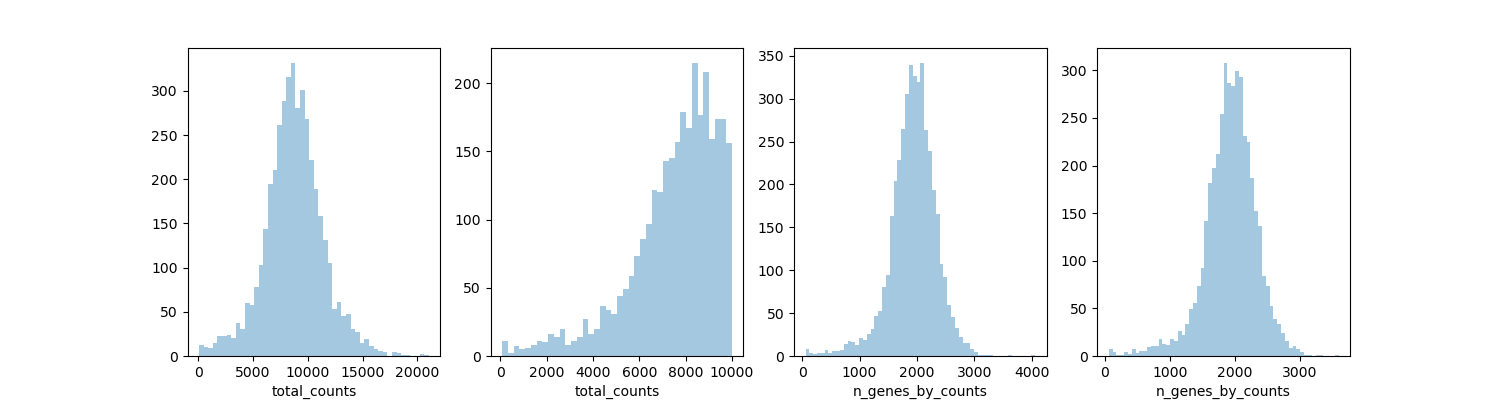

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categori

<IPython.core.display.Javascript object>


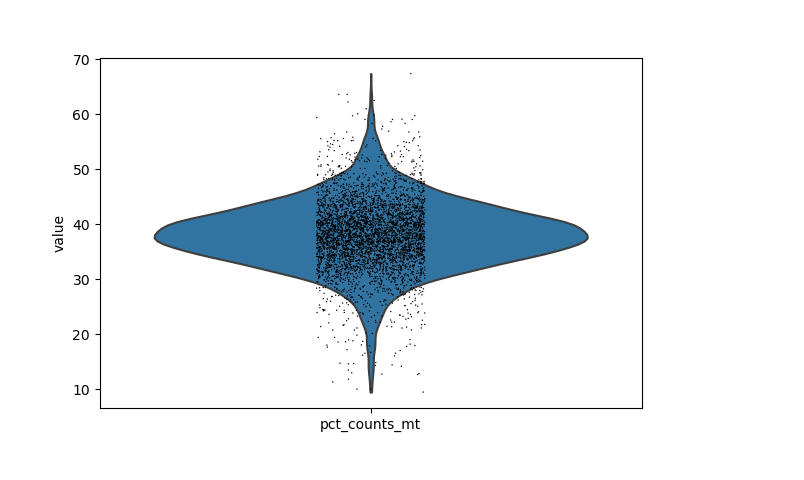

In [7]:
##Look at some basic QC metrics for the data

%matplotlib notebook

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
sc.pl.violin(adata,['pct_counts_mt'])

In [8]:
sc.pp.filter_cells(adata, min_counts=5000)
print(f'Number of cells after min count filter: {adata.n_obs}')
#sc.pp.filter_cells(adata, max_counts=20000)
print(f'Number of cells after max count filter: {adata.n_obs}')
adata = adata[adata.obs["pct_counts_mt"] < 60]
adata = adata[adata.obs["pct_counts_mt"] > 5]
print(f"#cells after MT filter: {adata.n_obs}")
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(adata, min_cells=10)
print(f'Number of genes after cell filter: {adata.n_vars}')
#sc.pp.filter_cells(adata, min_genes = 3000)
#print(f'Number of cells after gene filter: {adata.n_obs}')

Trying to set attribute `.var` of view, copying.


Number of cells after min count filter: 3940
Number of cells after max count filter: 3940
#cells after MT filter: 3934
Number of genes after cell filter: 15127


In [9]:
adata

AnnData object with n_obs × n_vars = 3934 × 15127
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
##Do normalisation and find highly variable genes
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

<IPython.core.display.Javascript object>


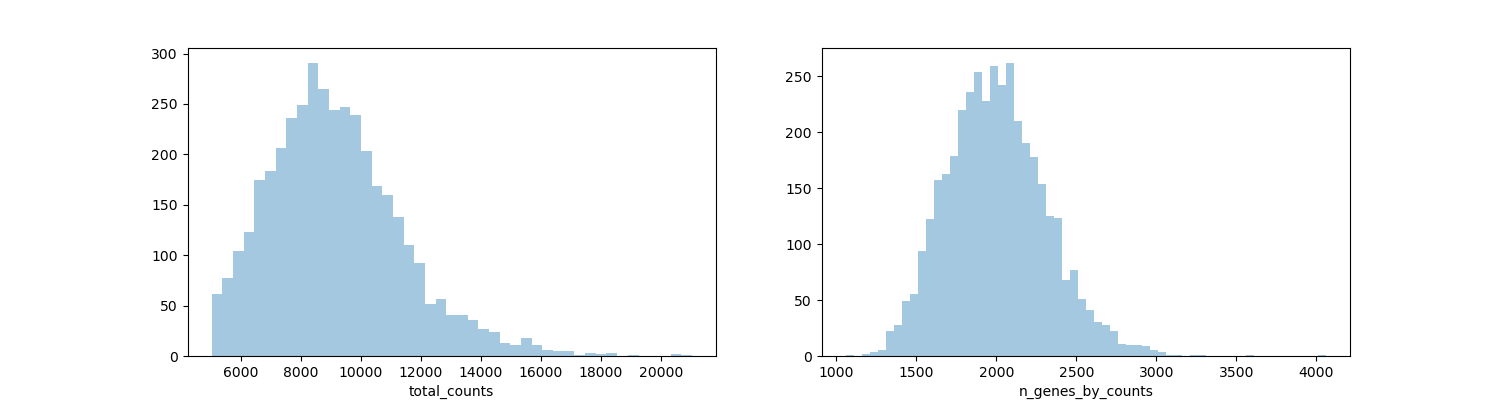

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

In [11]:
#Look at distribution after normalisation
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [12]:
highly_variable_genes = pd.DataFrame(adata.var.highly_variable)
highly_variable_genes = highly_variable_genes.loc[highly_variable_genes['highly_variable'] == True]
#highly_variable_genes.to_csv('HVGs_scanpy_V4.csv')

In [13]:
#Do next step in cluster identification
sc.pp.pca(adata,n_comps=20)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='clusters')

<IPython.core.display.Javascript object>


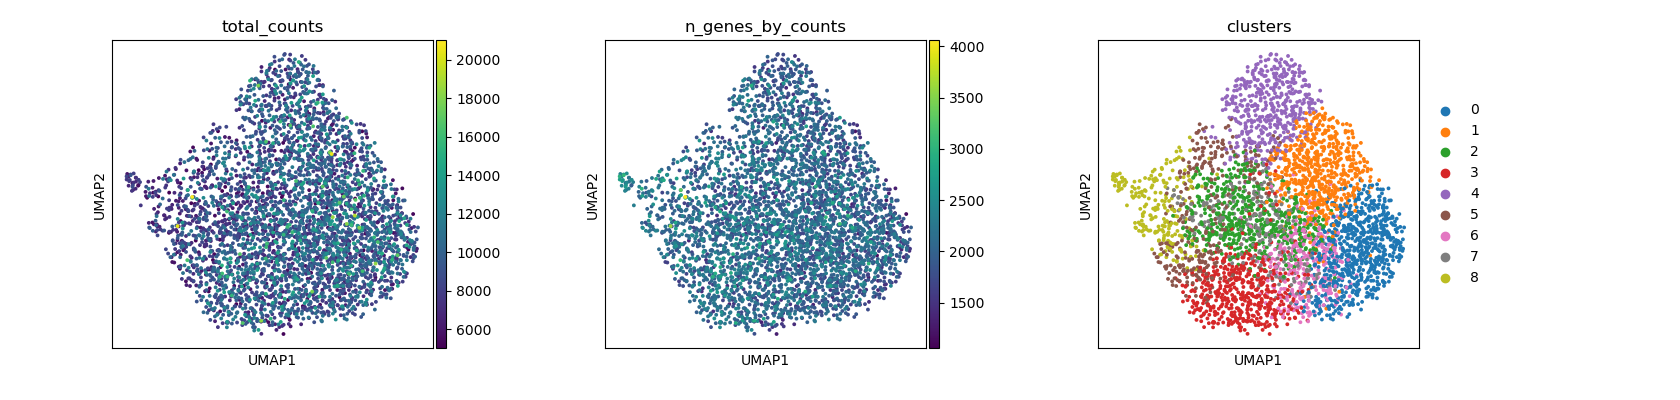

In [14]:
#Do some umap visualisations
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

<IPython.core.display.Javascript object>


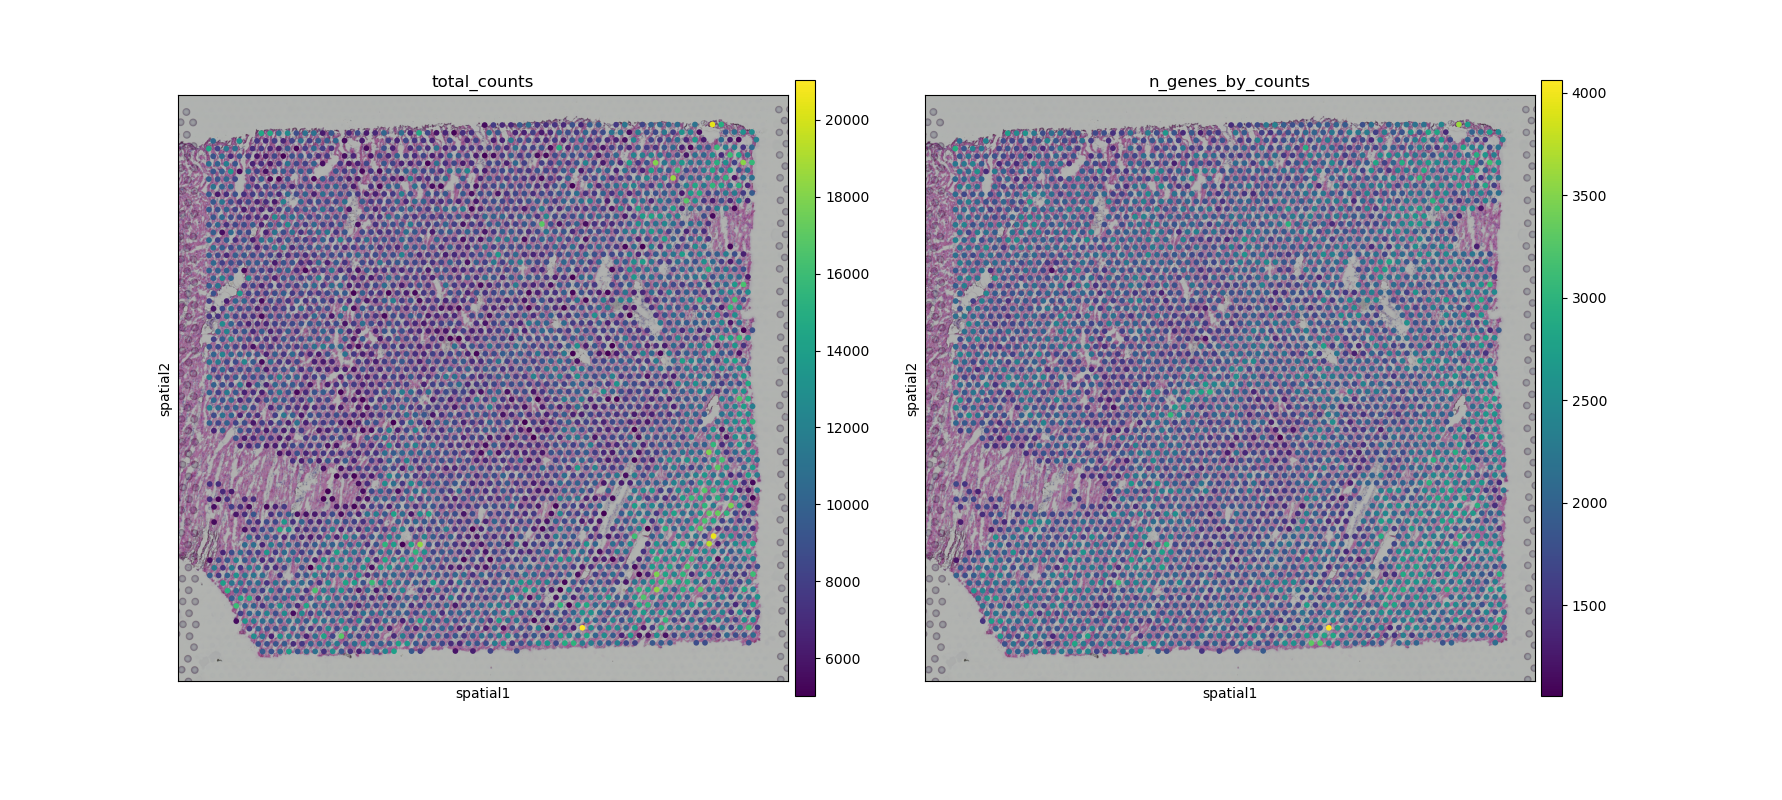

In [15]:
#Visualise in spatial coordinates
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])
#Seems like blood vessels are more visible here

<IPython.core.display.Javascript object>


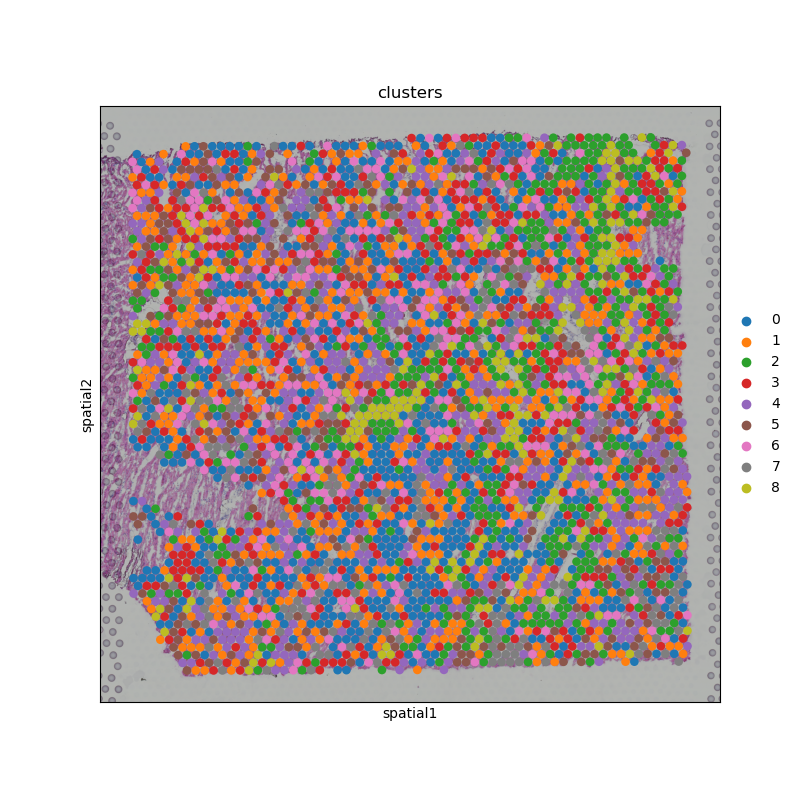

In [16]:
#Visualise cell type clusters by spatial organisation
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

categories: 0, 1, 2, etc.
var_group_labels: 5


<IPython.core.display.Javascript object>


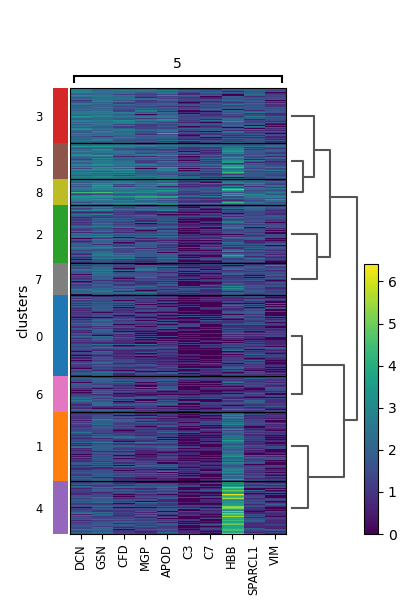

In [17]:
#Compute marker genes across all clusters and plot heatmap of the top 10 markers in each cluster
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="5", n_genes=10, groupby="clusters")

<IPython.core.display.Javascript object>


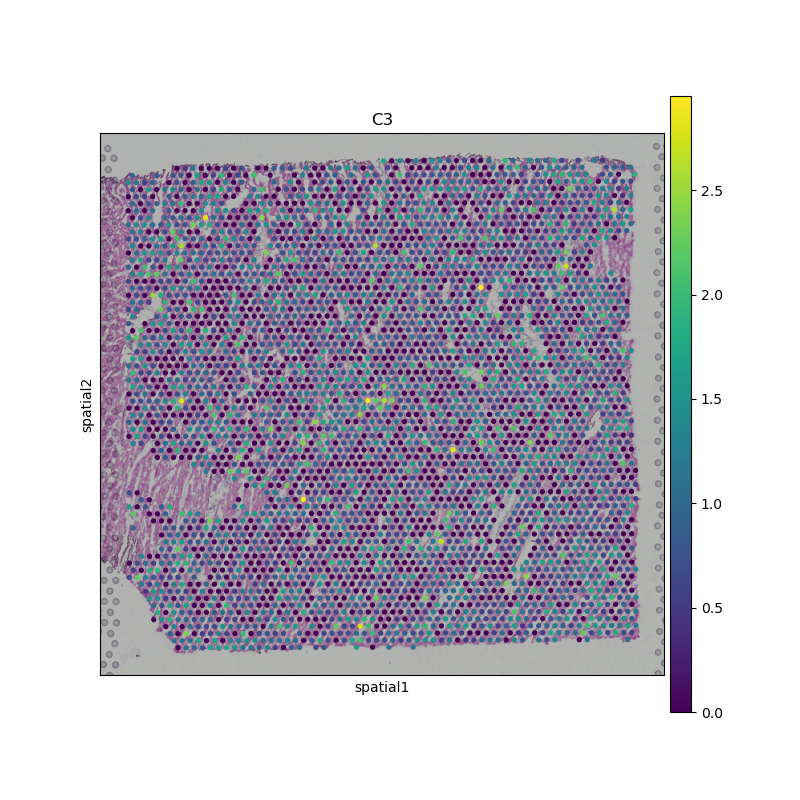

In [18]:
#Pick a gene to do a visualisation on the section - let's try c3 can fix this for presentation
#Can also do this alongside clusters
sc.pl.spatial(adata, img_key = "hires", color="C3")

## Write out files

In [20]:
##write this AnnData object to a didfferent file format
adata.write_h5ad(filename='ff_left_ventricle.h5ad', compression=None, compression_opts=None, force_dense=None, as_dense=())

In [22]:
#Write out normalised dataframe with expression values to file so it can be read back in for this purpose
adata.write_csvs('.',skip_data=False)

writing .csv files to /Users/natalie.charitakis/Documents/Documents - MCRI-U0197/Work/Projects/PhD Project/Benchmarking SRT/scanpy/V1_human_heart


### Identify SVGs with SpatialDE

In [23]:
%%time
#Now try and find SVGs with SpatialDE
#We need to convert normalised counts into a DF for spatial DE

counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord', 'y_coord'], index=adata.obs_names)
results = SpatialDE.run(coord, counts)

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15127 [00:00<?, ?it/s]

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/15127 [00:00<?, ?it/s]

  0%|          | 0/15127 [00:00<?, ?it/s]

  0%|          | 0/15127 [00:00<?, ?it/s]

  0%|          | 0/15127 [00:00<?, ?it/s]

  0%|          | 0/15127 [00:00<?, ?it/s]

  0%|          | 0/15127 [00:00<?, ?it/s]

  0%|          | 0/15127 [00:00<?, ?it/s]

  0%|          | 0/15127 [00:00<?, ?it/s]

  0%|          | 0/15127 [00:00<?, ?it/s]

CPU times: user 21min 46s, sys: 7.54 s, total: 21min 53s
Wall time: 22min 15s


In [ ]:
#Look at top 10 values
results.sort_values("qval").head(10)

In [ ]:
#Sort results for all qvals >= 0.05 and add them to file
results_filtered = results[results["qval"] <= 0.05]
results_filtered = results_filtered.sort_values(by="qval")
results_filtered.to_csv('ff_left_ventricle_sig_SVGs_spatialde.csv')
results_filtered